# Basic approximate bayesian computation on the RISC model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import helper

There are 4 different switches in the model that can be on or off, making for a total of 16 possibilities (numbered 0 to 15).

I've run each of these 16 models a total of 25 times and saved the results. I then ran history matching with the results, which found that models 12-15 are plausible (matching the results in the paper).

The model has three outputs (number of small, medium and large farms over time). Each output has it's own associated uncertainty. This is the sum of the ensemble variance and average model discrepancy (the average error between the simulation results and the empirical data).

Below, are these results.

In [2]:
k = 25  # number of ensembles run with results saved

# History matching results
plaus_space = [12, 13, 14, 15]  # indexes of the plausible models
# Each output has an individually measured uncertainty.
uncert = {'n small': 1.165, 'n medium': 1.484, 'n large': 2.561}

We want to test the probability that a given driver (set of switches) fits the data. To do this, we run each driver 25 times and see if the result is greater or less than a given threshold. If it is less then we accept it, otherwise we reject it. We use the total number of acceptances to derive the probability that the driver fits the model.

How we decide what this threshold should be is subjective. Initially, we'll it to be the uncertainties that were found during history matching.

In [3]:
posteriors = dict((x, 0) for x in plaus_space)
for driver_i in plaus_space:
    driver = helper.drivers[driver_i]
    for i in range(k):
        df = pd.read_csv(helper.get_fp(driver)[:-5] + str(i+1) + '.csv')
        passed = True  # assume passed until proven otherwise
        for output in helper.OUTPUTS:
            obs = helper.observations[output].tolist()
            est = df[output].tolist()
            d = helper.error_func(obs, est)  # compute distance
            # if one output fails to pass, the whole simulation fails
            if d > uncert[output]**2:
                passed = False
        if passed:
            posteriors[driver_i] += 1
print(posteriors)

{12: 25, 13: 25, 14: 0, 15: 0}


Drivers 12 and 13 passed the threshold in all of the 25 ensemble runs.
Drivers 14 and 15 failed for all ensemble runs.

**If the threshold was slightly higher, would drivers 14 and 15 pass?**
Next, we'll test the effects of using different thresholds by perturbing the originals. We'll change the threshold to be between -0.15 and +0.15 of the original (remember, each model output has a separate threshold).

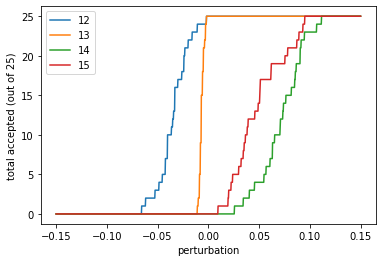

In [4]:
def run(perturb):
    #  perturb: a value stating how much to perturbate the uncertainty
    posteriors = dict((x, 0) for x in plaus_space)
    for driver_i in plaus_space:
        driver = helper.drivers[driver_i]
        for i in range(k):
            df = pd.read_csv(helper.get_fp(driver)[:-5] + str(i+1) + '.csv')
            passed = True  # assume passed until proven otherwise
            for output in helper.OUTPUTS:
                obs = helper.observations[output].tolist()
                est = df[output].tolist()
                d = helper.error_func(obs, est)  # compute distance
                # if one output fails to pass, the whole simulation fails
                if d > (uncert[output] + peturb)**2:
                    passed = False
            if passed:
                posteriors[driver_i] += 1
    return posteriors

perturbator = np.linspace(-0.15, 0.15, 1001)
Y = {12:[], 13:[], 14:[], 15:[]}
for peturb in perturbator:
    post = run(peturb)
    for ps in (12, 13, 14, 15):
        Y[ps].append(post[ps])
for ps in (12, 13, 14, 15):
    plt.plot(list(perturbator), Y[ps], label=str(ps))
plt.xlabel('perturbation')
plt.ylabel('total accepted (out of 25)')
plt.legend()
plt.show()

For drivers 12 and 13, a threshold any lower than the original results in rejections. For driver 13 every ensemble becomes rejected. For driver 12, there is a more gradual slope of rejections.

Driver 14 needs a threhold greater by 0.11 for all ensembles to be accepted and driver 15 needs an increase by 0.1.

**How significant is the difference between drivers 12 & 13 compared against drivers 14 & 15? There is a clear visual difference, but how do we determine if it's significant and is the original choice for the threshold (where perturbation = 0) a good one?**